In [1]:
import sys
import os
src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
from connector import spark_connector

In [3]:
import pandas as pd
import numpy as np
from pyspark.sql import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [4]:
spark_connector?

Init signature:
spark_connector(
    exec_inst: int = 100,
    exec_cores: int = 5,
    aloc_max: int = 500,
    memory_exec: int = 25,
    name: object = 'utopialvo',
    rootdir: object = 'remote_dir_in_hdft',
    enable_graphframes: bool = False,
    enable_clickhouse: bool = False,
    enable_postgres: bool = False,
    dynamic_allocation: bool = False,
    intensive_mode: bool = False,
    marshal_mode: bool = True,
    yarn: bool = True,
) -> None
Docstring:     
Класс стандартного подключения к Spark

exec_inst - количество контейнеров
exec_cores - количество ядер в контейнере
aloc_max - максимальное количество ядер для dynamic_allocation (если он вкл)
memory_exec - количество памяти в контейнере
name - название подключения для упрощения логгирования подключений в кластере
rootdir - корневая папка в HDFS 
enable_graphframes - включить работу с graphframes
enable_clickhouse - включить работу с clickhouse
enable_postgres - включить работу с postgres
dynamic_allocation - включить д

In [5]:
con = spark_connector(exec_inst=100, exec_cores=5, memory_exec=25, enable_graphframes=True, marshal_mode=False, yarn = False)

In [6]:
con.spark

In [7]:
#con.stop_spark()

In [8]:
from sklearn.datasets import make_blobs

In [9]:
X, y, c = make_blobs(n_samples=1000, n_features=3, centers=5, cluster_std=1.0, center_box=(-15.0, 15.0), shuffle=True, random_state=0, return_centers=True)

In [10]:
data = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(X.shape[1])])
data['y'] = y
data = data.merge(pd.DataFrame(c, columns=[f'centroids_{i+1}' for i in range(X.shape[1])]).reset_index(), left_on='y', right_on='index', how='left').drop('index', axis=1)

In [11]:
data

,x1,x2,x3,y,centroids_1,centroids_2,centroids_3
0,-3.599284,8.778047,1.077980,3,-3.496754,8.751751,0.866848
1,-0.274180,12.246721,14.191305,2,-1.872384,11.753190,13.909883
2,-4.585860,10.625505,0.604444,3,-3.496754,8.751751,0.866848
3,-2.776753,10.404694,14.655114,2,-1.872384,11.753190,13.909883
4,2.952788,6.780525,1.894759,0,1.464405,6.455681,3.082901
...,...,...,...,...,...,...,...
995,-2.960568,8.597261,0.996040,3,-3.496754,8.751751,0.866848
996,2.838154,12.410592,-12.004444,4,2.041337,12.767899,-12.868918
997,2.111185,6.091347,2.404124,0,1.464405,6.455681,3.082901
998,-3.546871,10.304264,-0.003761,3,-3.496754,8.751751,0.866848


In [12]:
import seaborn as sns

<Axes: xlabel='x1', ylabel='x2'>

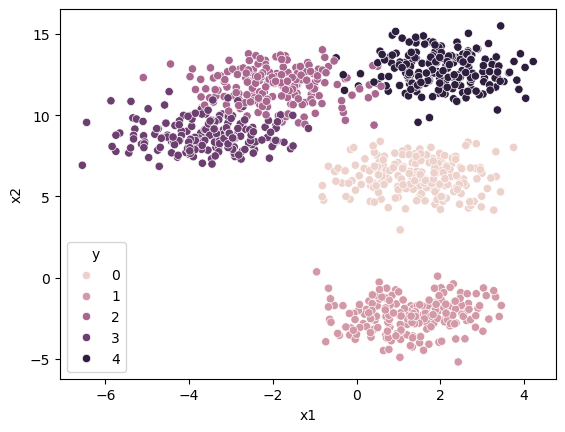

In [13]:
sns.scatterplot(x=data.x1, y=data.x2, hue=data.y)

<Axes: xlabel='centroids_1', ylabel='centroids_2'>

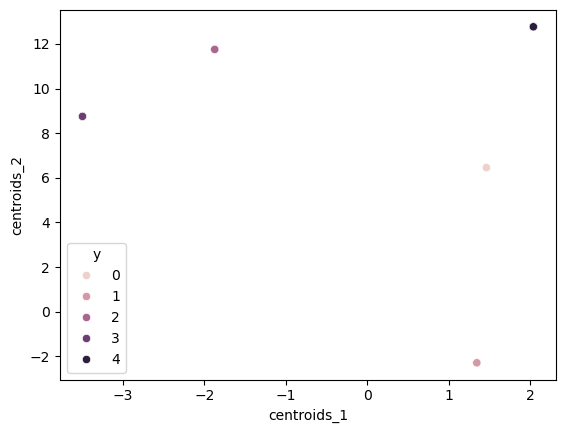

In [14]:
sns.scatterplot(x=data.centroids_1, y=data.centroids_2, hue=data.y)

In [15]:
data2 = data.reset_index(names='index_train')#.drop(['y','centroids_1','centroids_2'], axis=1)

In [16]:
data2

,index_train,x1,x2,x3,y,centroids_1,centroids_2,centroids_3
0,0,-3.599284,8.778047,1.077980,3,-3.496754,8.751751,0.866848
1,1,-0.274180,12.246721,14.191305,2,-1.872384,11.753190,13.909883
2,2,-4.585860,10.625505,0.604444,3,-3.496754,8.751751,0.866848
3,3,-2.776753,10.404694,14.655114,2,-1.872384,11.753190,13.909883
4,4,2.952788,6.780525,1.894759,0,1.464405,6.455681,3.082901
...,...,...,...,...,...,...,...,...
995,995,-2.960568,8.597261,0.996040,3,-3.496754,8.751751,0.866848
996,996,2.838154,12.410592,-12.004444,4,2.041337,12.767899,-12.868918
997,997,2.111185,6.091347,2.404124,0,1.464405,6.455681,3.082901
998,998,-3.546871,10.304264,-0.003761,3,-3.496754,8.751751,0.866848


In [17]:
train_df = con.spark.createDataFrame(data2)

# Normalizer

In [18]:
from norm import Normalizer, NormalizerPandas

In [19]:
normalizer = Normalizer(
    methods={
        'x1': 'zscore',
        'x2': 'zscore',
        'x3': 'minmax',
        'centroids_1': 'minmax',
        'centroids_2': 'range',
        'centroids_2': 'range'
    },
    columns=train_df.drop('index_train','y').columns
)
normalizer.fit(train_df)

In [20]:
df_normalized = normalizer.transform(train_df)

In [21]:
print(normalizer.stats)

{'x1': {'method': 'zscore', 'params': (-0.151917574383755, 2.4038078041366195)}, 'x2': {'method': 'zscore', 'params': (7.450964390439473, 5.490293124934582)}, 'x3': {'method': 'minmax', 'params': (-15.285315376239444, 16.291892813917276)}, 'centroids_1': {'method': 'minmax', 'params': (-3.496754435226668, 2.0413368328179686)}, 'centroids_2': {'method': 'range', 'params': (-2.290356019832858, 12.767899148779833, 7.4876330572124665)}}


In [22]:
df_normalized = df_normalized.toPandas()

<Axes: xlabel='x1', ylabel='x2'>

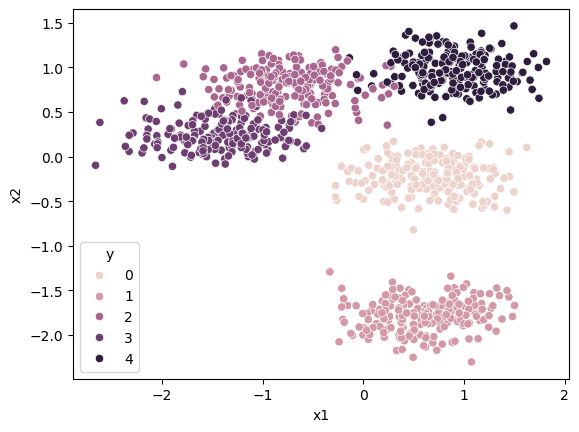

In [23]:
sns.scatterplot(x=df_normalized.x1, y=df_normalized.x2, hue=df_normalized.y)

<Axes: xlabel='centroids_1', ylabel='centroids_2'>

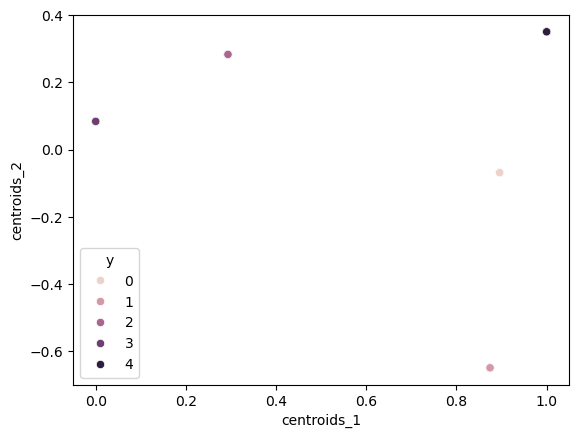

In [24]:
sns.scatterplot(x=df_normalized.centroids_1, y=df_normalized.centroids_2, hue=df_normalized.y)

In [25]:
normalizer.save?

Signature: normalizer.save(path: str) -> None
Docstring: Сохраняет параметры нормализации в файл
File:      ~/work/Spark_conn/src/norm.py
Type:      method

In [26]:
normalizer.save('norm.pkl')

In [27]:
normalizer.load?

Signature: normalizer.load(path: str) -> None
Docstring: Загружает параметры из файла и возвращает инициализированный объект
File:      ~/work/Spark_conn/src/norm.py
Type:      method

In [28]:
normalizer = Normalizer()
normalizer.load(path='norm.pkl')

In [29]:
print(normalizer.stats)

{'x1': {'method': 'zscore', 'params': (-0.151917574383755, 2.4038078041366195)}, 'x2': {'method': 'zscore', 'params': (7.450964390439473, 5.490293124934582)}, 'x3': {'method': 'minmax', 'params': (-15.285315376239444, 16.291892813917276)}, 'centroids_1': {'method': 'minmax', 'params': (-3.496754435226668, 2.0413368328179686)}, 'centroids_2': {'method': 'range', 'params': (-2.290356019832858, 12.767899148779833, 7.4876330572124665)}}


In [30]:
normalizer = Normalizer(
    method='minmax',
    columns=train_df.drop('index_train','y').columns
)
normalizer.fit(train_df)
df_normalized = normalizer.transform(train_df)

In [31]:
print(normalizer.stats)

{'x1': {'method': 'minmax', 'params': (-6.55108491236502, 4.219651692123145)}, 'x2': {'method': 'minmax', 'params': (-5.18315031555726, 15.491586903183482)}, 'x3': {'method': 'minmax', 'params': (-15.285315376239444, 16.291892813917276)}, 'centroids_1': {'method': 'minmax', 'params': (-3.496754435226668, 2.0413368328179686)}, 'centroids_2': {'method': 'minmax', 'params': (-2.290356019832858, 12.767899148779833)}, 'centroids_3': {'method': 'minmax', 'params': (-12.868918254063392, 13.90988281503088)}}


In [32]:
df_normalized = df_normalized.toPandas()

<Axes: xlabel='x1', ylabel='x2'>

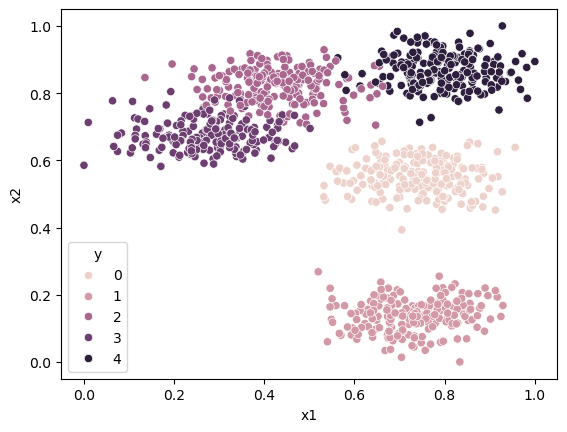

In [33]:
sns.scatterplot(x=df_normalized.x1, y=df_normalized.x2, hue=df_normalized.y)

In [34]:
normalizer = Normalizer(
    method='range',
    columns=train_df.drop('index_train','y').columns
)
normalizer.fit(train_df)
df_normalized = normalizer.transform(train_df)

In [35]:
print(normalizer.stats)

{'x1': {'method': 'range', 'params': (-6.55108491236502, 4.219651692123145, -0.151917574383755)}, 'x2': {'method': 'range', 'params': (-5.18315031555726, 15.491586903183482, 7.450964390439473)}, 'x3': {'method': 'range', 'params': (-15.285315376239444, 16.291892813917276, 1.9004107651586746)}, 'centroids_1': {'method': 'range', 'params': (-3.496754435226668, 2.0413368328179686, -0.10338013136025367)}, 'centroids_2': {'method': 'range', 'params': (-2.290356019832858, 12.767899148779833, 7.4876330572124665)}, 'centroids_3': {'method': 'range', 'params': (-12.868918254063392, 13.90988281503088, 1.873507365540744)}}


In [36]:
df_normalized = df_normalized.toPandas()

<Axes: xlabel='x1', ylabel='x2'>

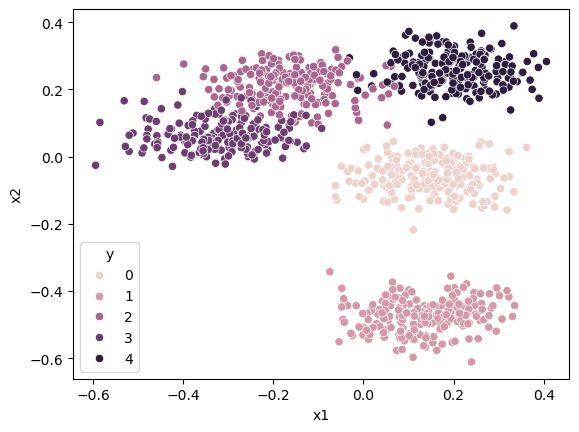

In [37]:
sns.scatterplot(x=df_normalized.x1, y=df_normalized.x2, hue=df_normalized.y)

# Pandas

In [38]:
df_normalized = train_df.toPandas()

In [39]:
normalizer = NormalizerPandas(
    methods={
        'x1': 'zscore',
        'x2': 'zscore',
        'x3': 'minmax',
        'centroids_1': 'minmax',
        'centroids_2': 'range',
        'centroids_2': 'range'
    },
    columns=df_normalized.drop(['index_train','y'], axis=1).columns
)
normalizer.fit(df_normalized)

In [40]:
df_normalized = normalizer.transform(df_normalized)

In [41]:
print(normalizer.stats)

{'x1': {'method': 'zscore', 'mean': -0.15191757438375514, 'std': 2.4038078041366173}, 'x2': {'method': 'zscore', 'mean': 7.450964390439461, 'std': 5.490293124934584}, 'x3': {'method': 'minmax', 'min': -15.285315376239444, 'max': 16.291892813917276}, 'centroids_1': {'method': 'minmax', 'min': -3.496754435226668, 'max': 2.0413368328179686}, 'centroids_2': {'method': 'range', 'min': -2.290356019832858, 'max': 12.767899148779833, 'mean': 7.4876330572123795}}


In [42]:
normalizer.load?

Signature: normalizer.load(path: str) -> None
Docstring: Загружает параметры из файла и возвращает инициализированный объект
File:      ~/work/Spark_conn/src/norm.py
Type:      method

In [43]:
normalizer.save?

Signature: normalizer.save(path: str) -> None
Docstring: Сохраняет параметры нормализации в файл
File:      ~/work/Spark_conn/src/norm.py
Type:      method

In [45]:
#con.stop_spark()

time: 2025-02-25 16:21:55.413742
del
stop
